In [1]:
# Importing data and libraries

import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt

DATA_DIR = "data/"
ais = pd.read_csv('training_set.csv', parse_dates = ['timestamp'])
ais = ais.sort_values(by=['mmsi', 'timestamp'])
ais.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,timestamp,mmsi,lat,lon,speed,course,heading,turnrate,vessel_id,vessel_src,breadth,vessel_type,vessel_max_speed,draft,power,length,dwt,iceclass,verified
0,20219,2017-11-02 11:19:07,205366000,54.347242,9.991140,4.01,56.6,56.0,0.0,3204,2,21.33,T,16.0,8.18,5820.0,143.18,13289.0,IA,N
1,20220,2017-11-02 11:30:58,205366000,54.360348,10.025337,4.17,77.5,81.0,0.0,3204,2,21.33,T,16.0,8.18,5820.0,143.18,13289.0,IA,N
2,20221,2017-11-02 11:37:58,205366000,54.359573,10.049203,4.48,92.4,92.0,0.0,3204,2,21.33,T,16.0,8.18,5820.0,143.18,13289.0,IA,N
3,20222,2017-11-02 11:44:07,205366000,54.365497,10.071320,3.81,44.9,46.0,0.0,3204,2,21.33,T,16.0,8.18,5820.0,143.18,13289.0,IA,N
4,20223,2017-11-02 11:56:08,205366000,54.370437,10.109498,2.73,103.6,103.0,0.0,3204,2,21.33,T,16.0,8.18,5820.0,143.18,13289.0,IA,N


In [2]:
stopped = ais.loc[ais.speed == 0]
stopped = stopped[stopped.vessel_type.isin(set(['GC', 'T', 'PAS', 'CONT', 'RORO']))]

In [3]:
stopped.head()
len(stopped.lat)

3886225

In [8]:
stopped = stopped[['lat', 'lon']]
stopped.describe()

,lat,lon
count,3.292580e+06,3.292580e+06
mean,5.807262e+01,1.826314e+01
std,2.669443e+00,6.043491e+00
min,5.349231e+01,9.423667e+00
25%,5.570058e+01,1.201336e+01
50%,5.808845e+01,1.814013e+01
75%,5.987697e+01,2.295216e+01
max,6.579101e+01,3.059808e+01


In [9]:
from pygradu import gridify
import importlib

grid = gridify.area_to_grid(side_length=5000)

Original NE: POINT (31.5 66.8)
Original SW: POINT (8.5 53)
Transformed NE: (697681.2863658136, 7416224.9393330095)
Transformed SW: (-735260.4063631196, 6033964.466017238)
col_count 286
row_count 276
grid_size 78936


In [10]:
%time stopped['grid_point'] = stopped.apply(lambda row: grid.get_grid_point(row.lat, row.lon), axis=1)

CPU times: user 2min 8s, sys: 1.1 s, total: 2min 9s
Wall time: 2min 13s


In [11]:
%time stopped['node'] = stopped.apply(lambda row: grid.get_grid_position(row), axis=1)

CPU times: user 2min 22s, sys: 2.62 s, total: 2min 24s
Wall time: 2min 24s


In [12]:
stopped.head()

,lat,lon,grid_point,node
436145,57.690283,11.842383,"(-399062.71127494867, 6495670.7690037)",25182
437048,57.690283,11.842367,"(-399063.6894722582, 6495670.992977276)",25182
438221,57.690283,11.842367,"(-399063.6894722582, 6495670.992977276)",25182
439282,57.690267,11.842367,"(-399064.10770440253, 6495669.166362877)",25182
440326,57.690267,11.842367,"(-399064.10770440253, 6495669.166362877)",25182


In [17]:
stopped_south = stopped[stopped.lat < 60]
len(stopped_south.lat)

2609050

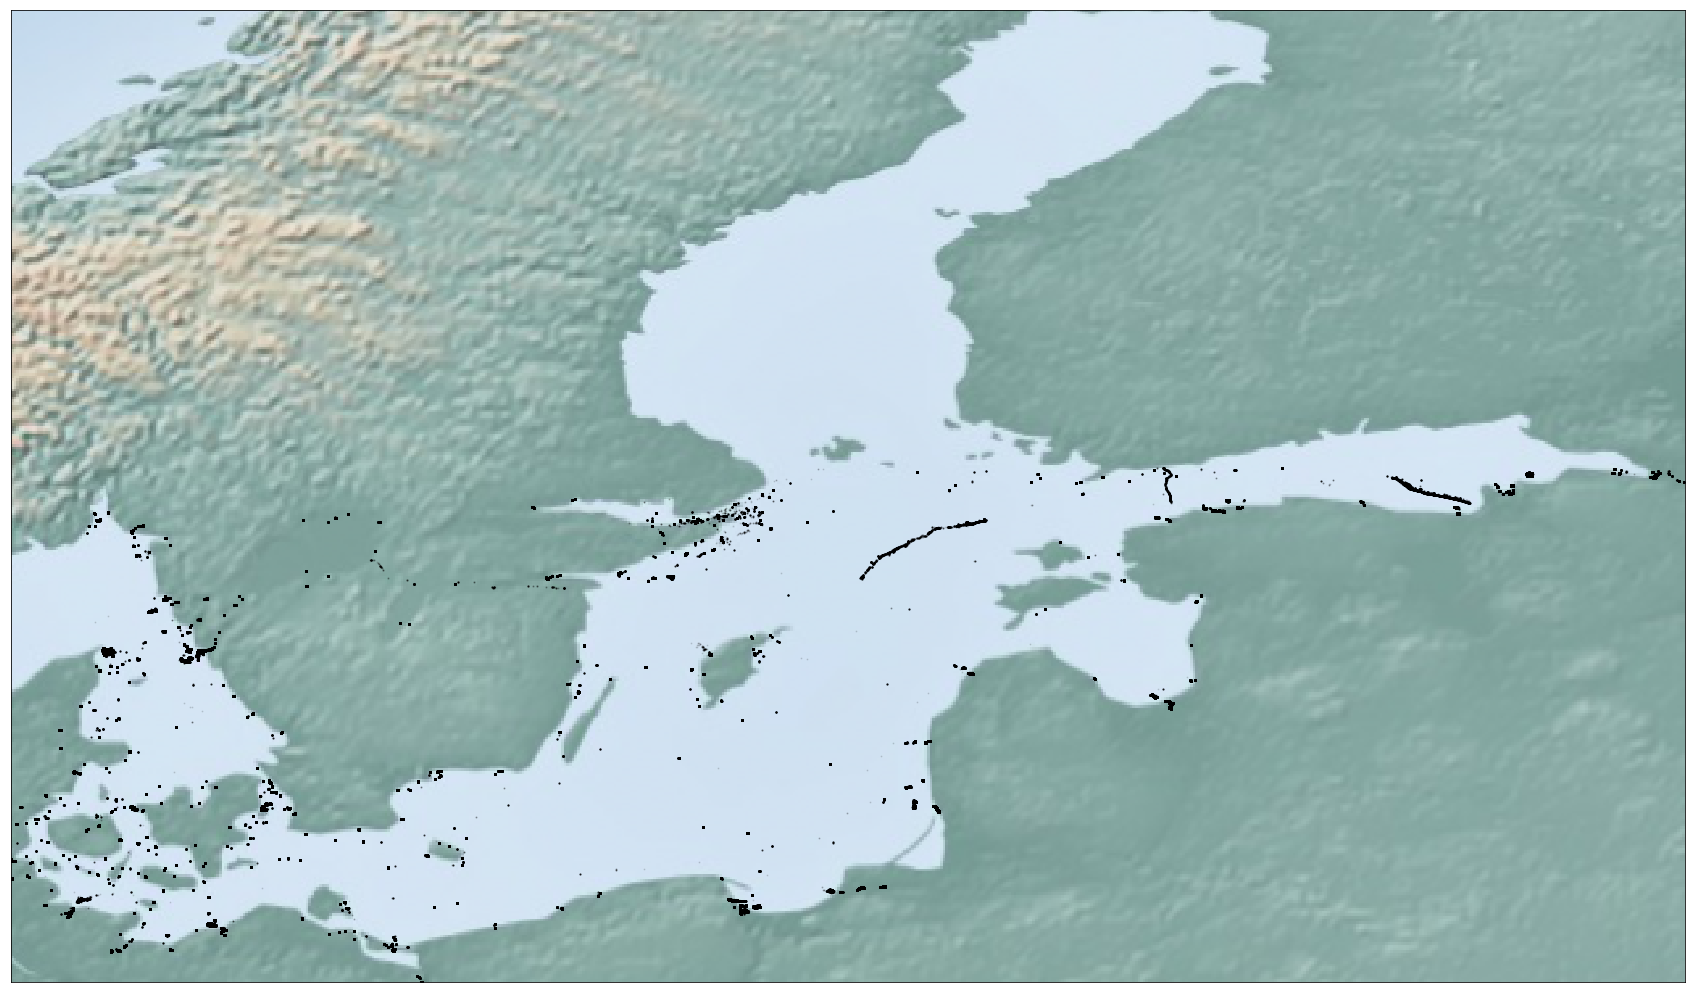

In [18]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap  # import Basemap matplotlib toolkit

fig = plt.figure(figsize=(30,30))
m = Basemap(llcrnrlon = stopped.lon.min(),llcrnrlat = stopped.lat.min(), urcrnrlon = stopped.lon.max(),
       urcrnrlat = stopped.lat.max(),
       resolution='l')
m.shadedrelief()

#data = pred_routes[(pred_routes.voyage == voyage)]

xy = stopped_south.loc[:, ('lat', 'lon')]
#print(xy)
plt.plot(xy.loc[:, ('lon')], xy.loc[:, ('lat')], 'o', c='black', alpha=0.1, markersize=1)

In [28]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
#from mpl_toolkits.basemap import Basemap

data = stopped_south[['lon', 'lat', 'node']]
#data = ais[['lon', 'lat', 'port_id', 'port_lat', 'port_lon']]
data = data.head(100000).values
#data = data.values

eps = 0.1
min_count = 200
%time db = DBSCAN(eps=eps, min_samples=min_count).fit(data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Total number of points: %d' % len(stopped.lat.tolist()))
print('Estimated number of noise points: %d' % n_noise_)


CPU times: user 2.86 s, sys: 987 ms, total: 3.85 s
Wall time: 3.86 s
Estimated number of clusters: 90
Total number of points: 3292580
Estimated number of noise points: 4844


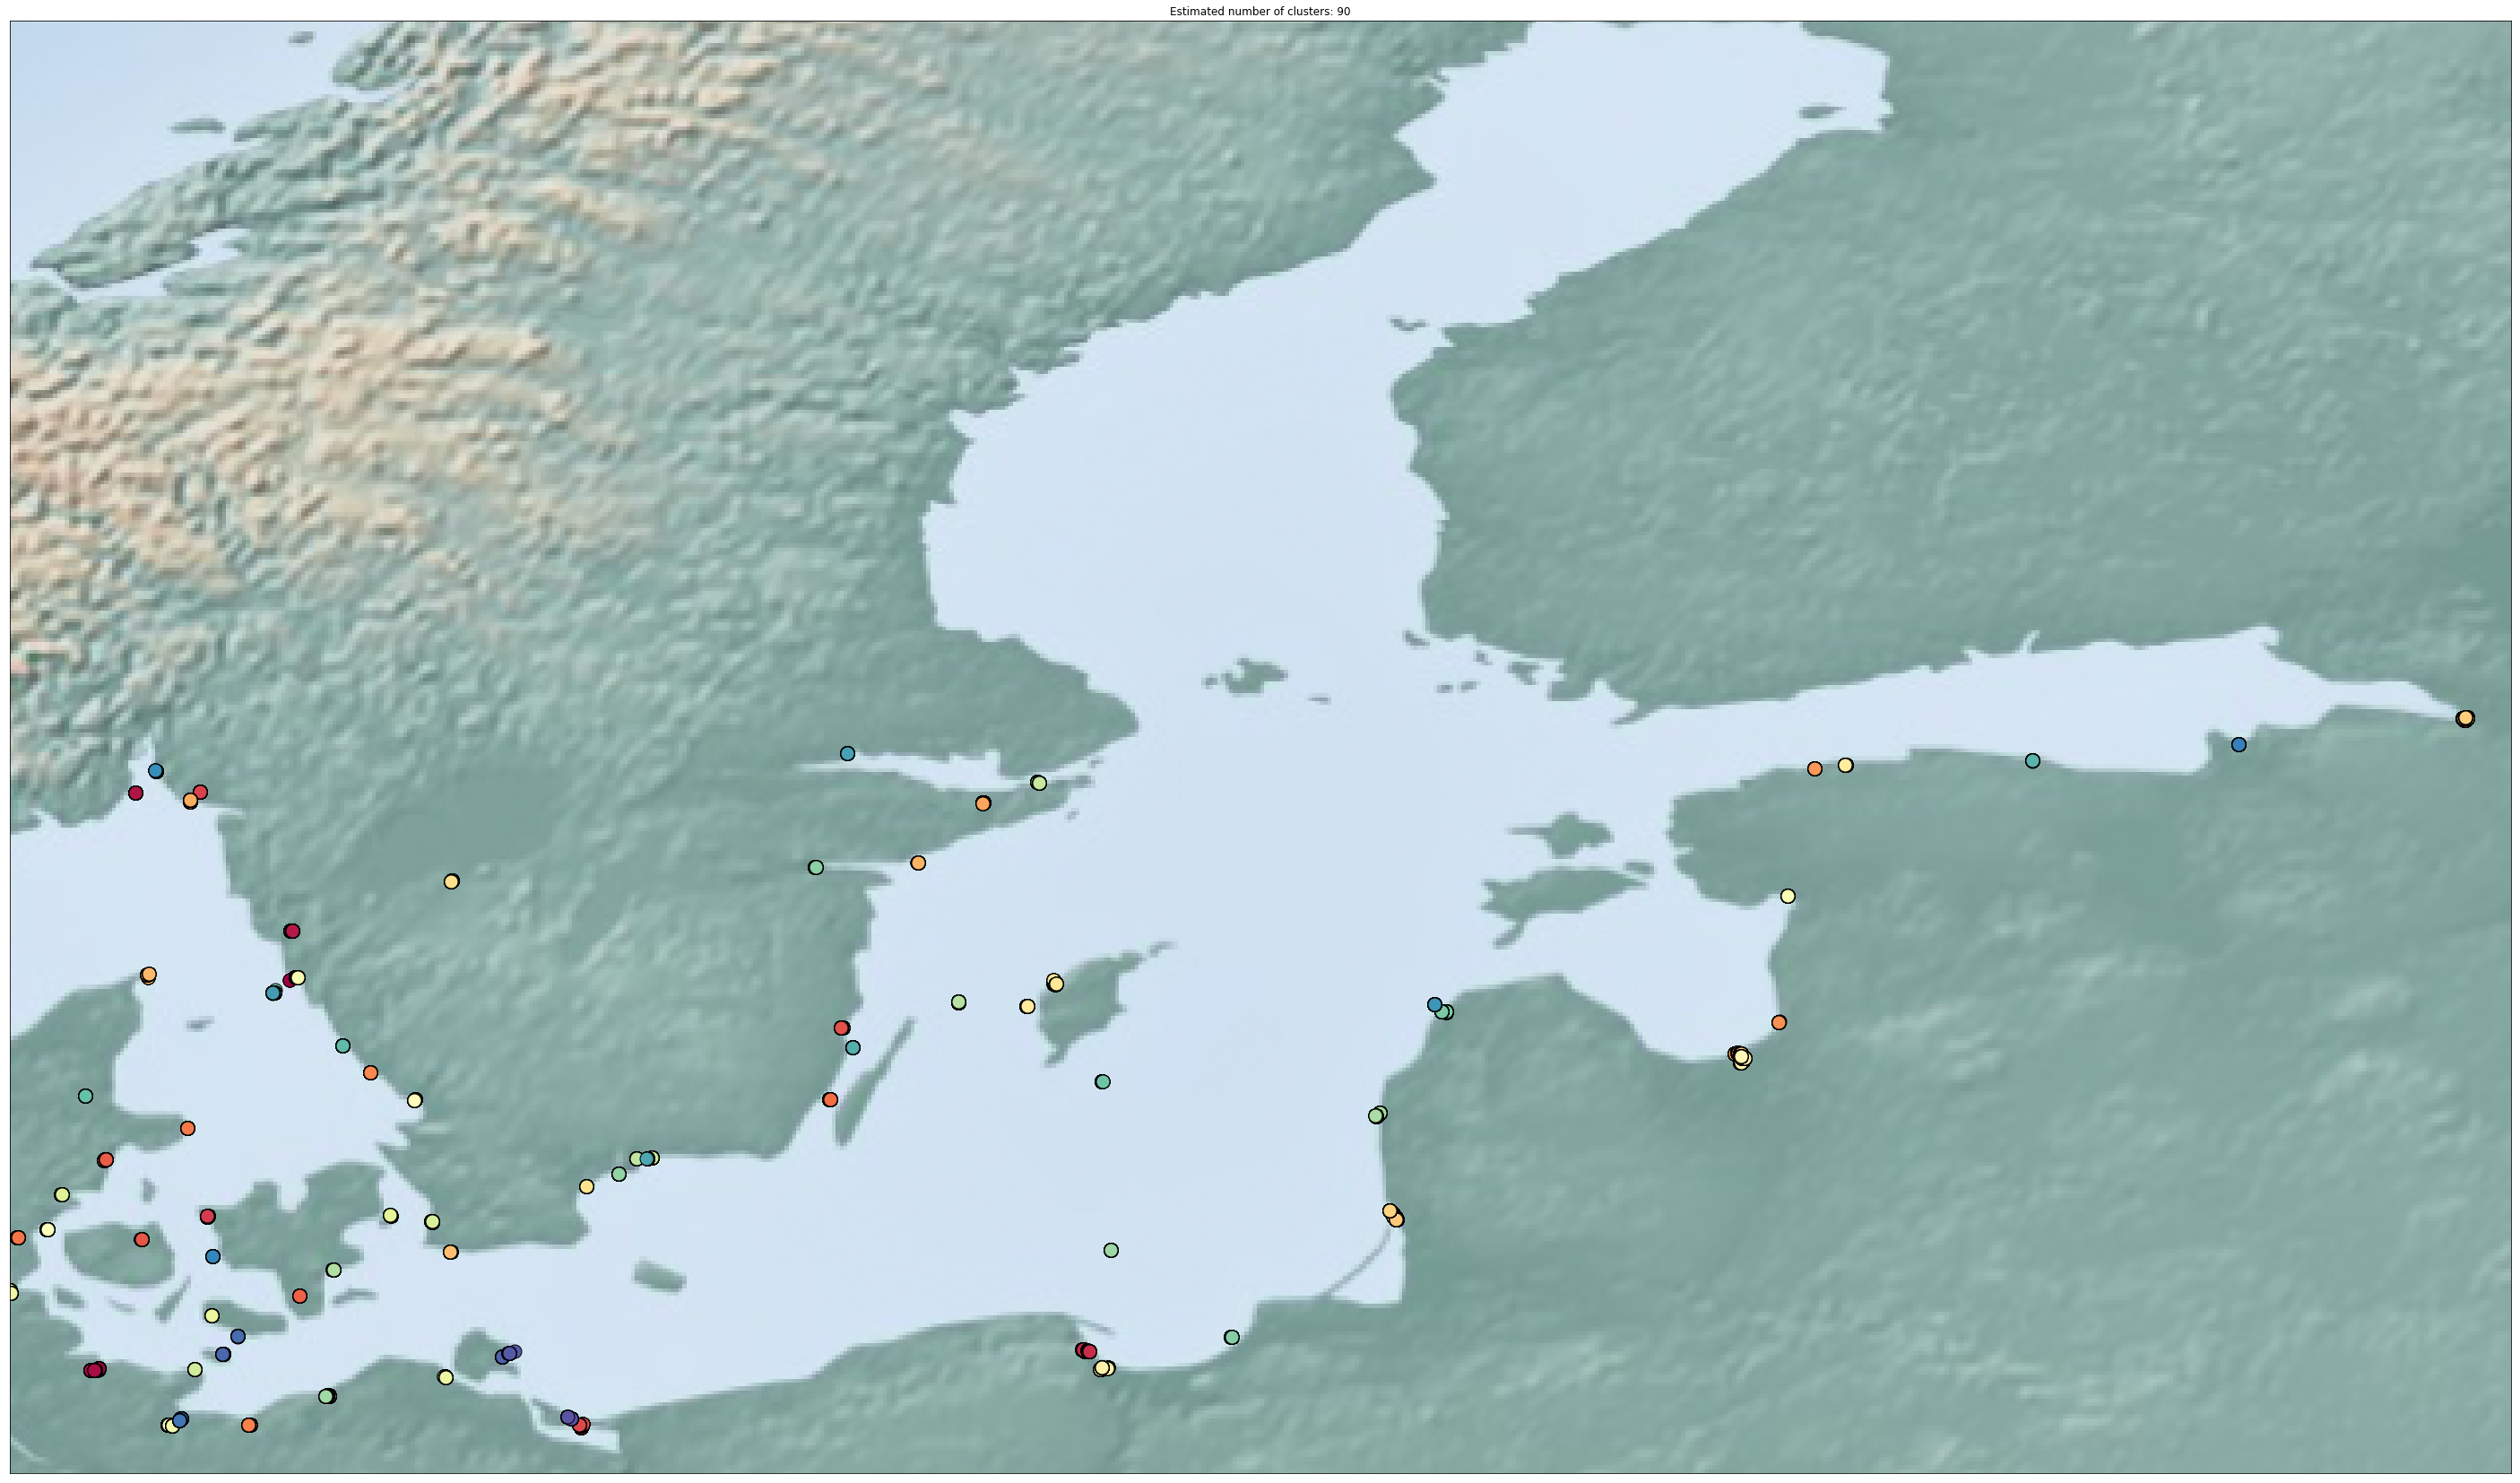

In [46]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap  # import Basemap matplotlib toolkit

fig = plt.figure(figsize=(50,50))
m = Basemap(llcrnrlon = stopped.lon.min(),llcrnrlat = stopped.lat.min(), urcrnrlon = stopped.lon.max(),
           urcrnrlat = stopped.lat.max(),
           resolution='l')
m.shadedrelief()

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

clusters = []
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        continue

    class_member_mask = (labels == k)

    xy = data[class_member_mask & core_samples_mask]
    clusters.append([xy[:, 1], xy[:, 0], xy[:, 2]])
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=15)

    #xy = data[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
    #         markeredgecolor='k', markersize=5)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [68]:
clusters_df = pd.DataFrame(data=clusters, columns=['lat', 'lon', 'node'])
print(len(clusters_df))
clusters_df.head()

90


,lat,lon,node
0,"[57.69028333333333, 57.69028333333333, 57.6902...","[11.842383333333334, 11.842366666666667, 11.84...","[25182.0, 25182.0, 25182.0, 25182.0, 25182.0, ..."
1,"[54.37084333333333, 54.37011666666667, 54.3718...","[10.169335, 10.173805, 10.173886666666666, 10....","[6653.0, 6653.0, 6653.0, 6653.0, 6653.0, 6653...."
2,"[54.365581666666664, 54.365585, 54.36559833333...","[10.143066666666666, 10.143071666666666, 10.14...","[6652.0, 6652.0, 6652.0, 6652.0, 6652.0, 6652...."
3,"[59.258415, 59.25845666666667, 59.258455000000...","[10.491885, 10.491905, 10.491965, 10.491916666...","[35663.0, 35663.0, 35663.0, 35663.0, 35663.0, ..."
4,"[58.08643333333333, 58.08643333333333, 58.0864...","[11.803683333333336, 11.803683333333336, 11.80...","[27668.0, 27668.0, 27668.0, 27668.0, 27668.0, ..."


In [69]:
import statistics

ports = clusters_df
%time ports['lat'] = clusters_df.apply(lambda row: statistics.mean(row.lat), axis=1)
%time ports['lon'] = clusters_df.apply(lambda row: statistics.mean(row.lon), axis=1)
%time ports['id'] = clusters_df.apply(lambda row: int(statistics.mean(row.node)), axis=1)

CPU times: user 165 ms, sys: 2.74 ms, total: 168 ms
Wall time: 167 ms
CPU times: user 158 ms, sys: 629 µs, total: 158 ms
Wall time: 158 ms
CPU times: user 136 ms, sys: 1.57 ms, total: 137 ms
Wall time: 138 ms


In [70]:
ports.head()

,lat,lon,node,id
0,57.689202,11.847573,"[25182.0, 25182.0, 25182.0, 25182.0, 25182.0, ...",25182
1,54.381692,10.178677,"[6653.0, 6653.0, 6653.0, 6653.0, 6653.0, 6653....",6653
2,54.366730,10.131996,"[6652.0, 6652.0, 6652.0, 6652.0, 6652.0, 6652....",6652
3,59.258447,10.491923,"[35663.0, 35663.0, 35663.0, 35663.0, 35663.0, ...",35663
4,58.087629,11.811959,"[27668.0, 27668.0, 27668.0, 27668.0, 27668.0, ...",27668


In [97]:
len(ports)
remove = ports[(ports.lat < 57) & (ports.lat > 55.2) & (ports.lon > 17.5) & (ports.lon < 19.8)].id
ports = ports[~ports.id.isin(remove)]
remove = ports[(ports.lat > 57) & (ports.lat < 58.2) & (ports.lon < 17.9) & (ports.lon > 17.1)].id
ports = ports[~ports.id.isin(remove)]

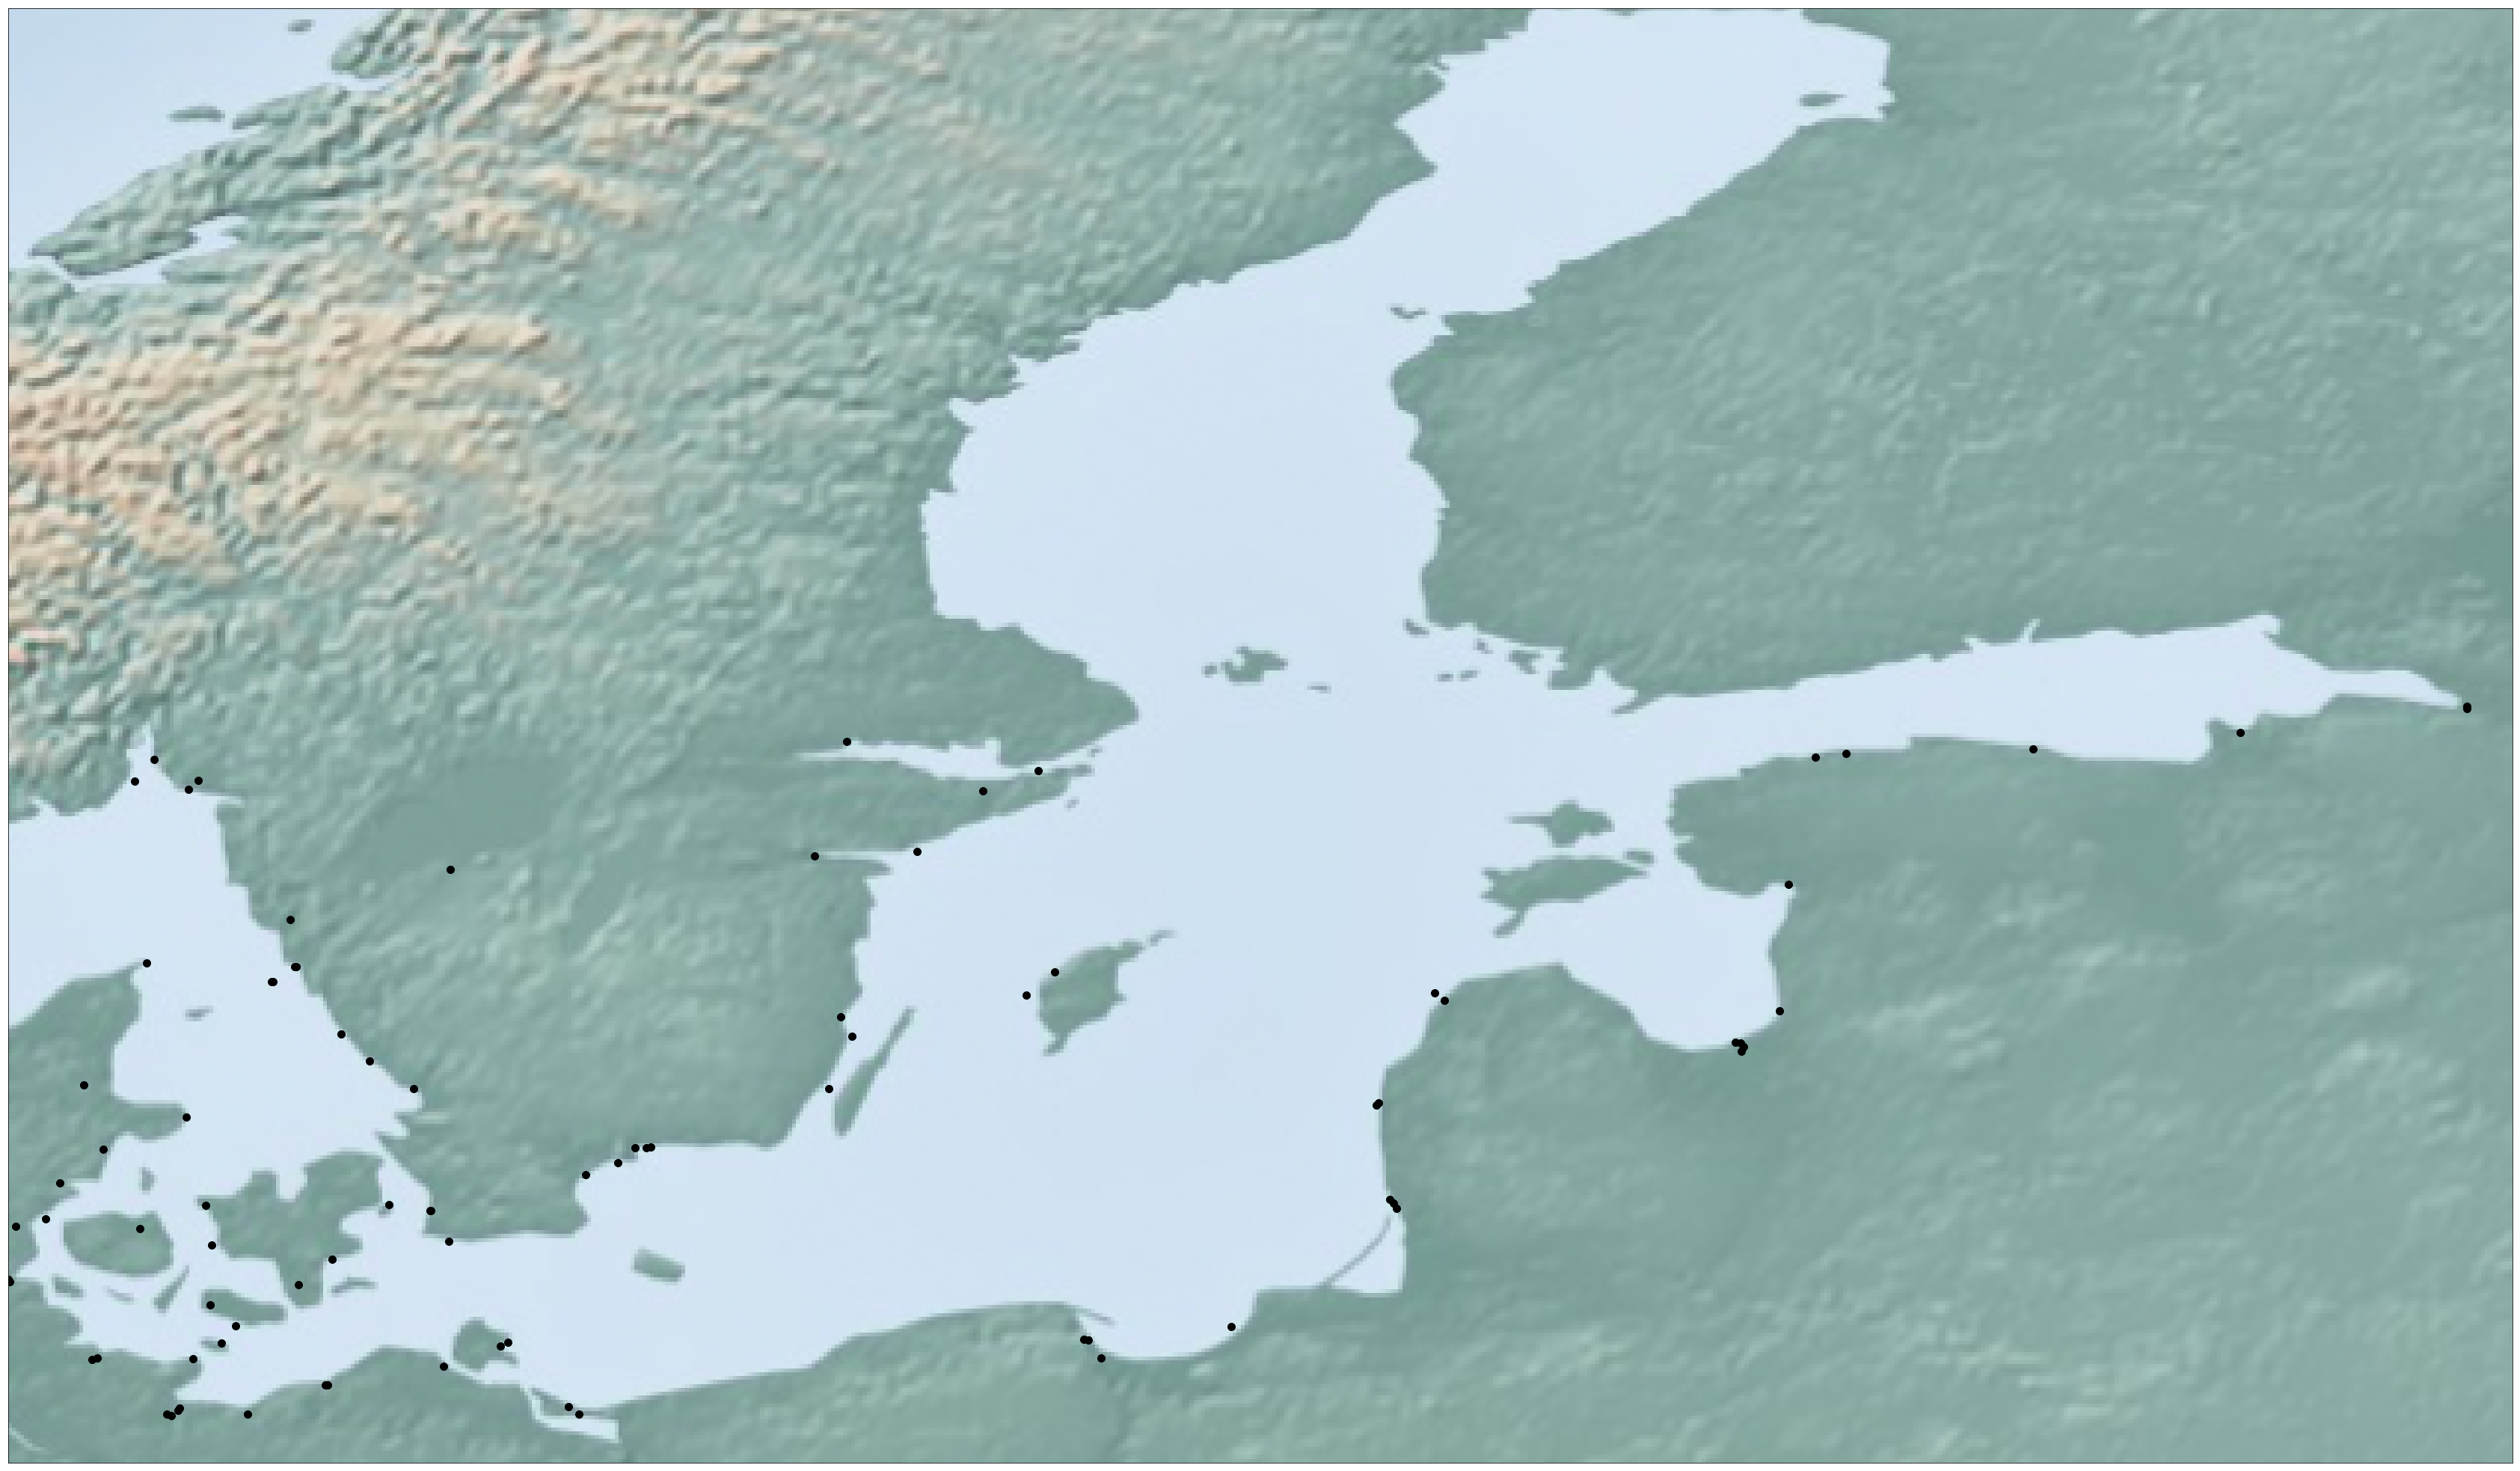

In [98]:
fig = plt.figure(figsize=(60,60))
m = Basemap(llcrnrlon = stopped.lon.min(),llcrnrlat = stopped.lat.min(), urcrnrlon = stopped.lon.max(),
           urcrnrlat = stopped.lat.max(),
           resolution='l')
m.shadedrelief()

xy = ports.loc[:, ('lat', 'lon')]
plt.plot(xy.loc[:, ('lon')], xy.loc[:, ('lat')], 'o', c='black', alpha=1, markersize=10)
plt.show()

In [99]:
ports.to_csv('ports_calculated_from_ais.csv')